# Tugas Besar Pembelajaran Mesin 2

### Persiapan Data

Hal pertama yang kami lakukan adalah menggunakan data latih Weather Categorization dari WEKA. 

In [1]:
import pandas as pd
import numpy as py

In [2]:
weather_df = pd.read_csv('dataset/weather.csv')

weather_df

,outlook,temperature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes
5,rainy,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rainy,75,80,False,yes


Dapat dilihat data latih terdiri dari data numerik dan data kategorikal. Diperlukan preprocessing dengan kakas scikit-learn yaitu LabelEncoder sebagai berikut.

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
label_encoder = LabelEncoder()
weather_df['outlook'] = label_encoder.fit_transform(weather_df.outlook)
weather_df['windy'] = label_encoder.fit_transform(weather_df.windy)
weather_df['play'] = label_encoder.fit_transform(weather_df.play)

In [5]:
weather_df

,outlook,temperature,humidity,windy,play
0,2,85,85,0,0
1,2,80,90,1,0
2,0,83,86,0,1
3,1,70,96,0,1
4,1,68,80,0,1
5,1,65,70,1,0
6,0,64,65,1,1
7,2,72,95,0,0
8,2,69,70,0,1
9,1,75,80,0,1


In [6]:
X_weather = weather_df.iloc[:,:4].values
X_weather

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1],
       [ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [7]:
y_weather = weather_df.play.values
y_weather

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

Kemudian, setelah kami menjadikan data latih tersebut numerik, kami melakukan pemisahan sebagian data latih (10%) menjadi data uji dengan proporsi.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_weather, y_weather, test_size=0.1,shuffle=False)

In [10]:
X_train

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1]])

In [11]:
X_test

array([[ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [12]:
y_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [13]:
y_test

array([1, 0])

### Explorasi Keras (1.b)

Pembelajaran akan menggunakan kakas keras dengan model <i>sequential</i> dan lapisan <i>dense</i>.

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


Model akan memakai input layer sebanyak 4 neuron dengan bentuk input 4 sesuai jumlah attribute data latih, kemudian dengan 2 hidden layer masing-masing 2 neuron kemudian 10 neuron, dan 1 output layer dengan 1 neuron.

In [15]:
models = Sequential()
models.add(Dense(4, activation='sigmoid', input_shape=(4,)))
models.add(Dense(2, activation='sigmoid'))
models.add(Dense(10, activation='sigmoid'))
models.add(Dense(1, activation='sigmoid'))

Optimizer yang dipakai adalah Adam (Adaptive Moment Estimation), dengan perhitungan loss dengan Mean Squared Error, dan Metrics Accuracy.

In [16]:
models.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Berikut adalah summary dari model yang akan dipakai.

In [17]:
models.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


Berikut adalah eksperimen yang dilakukan dengan batch = 1 dan sesuai jumlah data.

<b> Batch = 1 </b>

In [18]:
history1 = models.fit(X_train, y_train, epochs=200, verbose=1, batch_size=1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/200
10/10 [==============================] - 0s 19ms/step - loss: 0.3285 - acc: 0.4000 - val_loss: 0.4796 - val_acc: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 0s 996us/step - loss: 0.3234 - acc: 0.4000 - val_loss: 0.4669 - val_acc: 0.0000e+00
Epoch 3/200
10/10 [==============================] - 0s 1ms/step - loss: 0.3179 - acc: 0.4000 - val_loss: 0.4556 - val_acc: 0.0000e+00
Epoch 4/200
10/10 [==============================] - 0s 1ms/step - loss: 0.3137 - acc: 0.4000 - val_loss: 0.4434 - val_acc: 0.0000e+00
Epoch 5/200
10/10 [==============================] - 0s 1ms/step - loss: 0.3088 - acc: 0.4000 - val_loss: 0.4318 - val_acc: 0.0000e+00
Epoch 6/200
10/10 [==============================] - 0s 1ms/step - loss: 0.3040 - acc: 0.4000 - val_loss: 0.4212 - val_acc: 0.0000e+00
Epoch 7/200
10/10 [==============================] - 0s 1ms/step - loss: 0.3014 - acc: 0.4000 - val_loss: 0.4079 - val_acc: 0.0000e+00
Epoch 8/2

10/10 [==============================] - 0s 987us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1826 - val_acc: 1.0000
Epoch 62/200
10/10 [==============================] - 0s 931us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1814 - val_acc: 1.0000
Epoch 63/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1810 - val_acc: 1.0000
Epoch 64/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1799 - val_acc: 1.0000
Epoch 65/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2407 - acc: 0.6000 - val_loss: 0.1799 - val_acc: 1.0000
Epoch 66/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2408 - acc: 0.6000 - val_loss: 0.1782 - val_acc: 1.0000
Epoch 67/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2406 - acc: 0.6000 - val_loss: 0.1773 - val_acc: 1.0000
Epoch 68/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2407 - ac

Epoch 123/200
10/10 [==============================] - 0s 975us/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1624 - val_acc: 1.0000
Epoch 124/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1613 - val_acc: 1.0000
Epoch 125/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1622 - val_acc: 1.0000
Epoch 126/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1628 - val_acc: 1.0000
Epoch 127/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2405 - acc: 0.6000 - val_loss: 0.1609 - val_acc: 1.0000
Epoch 128/200
10/10 [==============================] - 0s 972us/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1618 - val_acc: 1.0000
Epoch 129/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1614 - val_acc: 1.0000
Epoch 130/200
10/10 [==============================] - 0s 986us/s

10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1592 - val_acc: 1.0000
Epoch 185/200
10/10 [==============================] - 0s 916us/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1589 - val_acc: 1.0000
Epoch 186/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2408 - acc: 0.6000 - val_loss: 0.1576 - val_acc: 1.0000
Epoch 187/200
10/10 [==============================] - 0s 914us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1610 - val_acc: 1.0000
Epoch 188/200
10/10 [==============================] - 0s 909us/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1607 - val_acc: 1.0000
Epoch 189/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2404 - acc: 0.6000 - val_loss: 0.1594 - val_acc: 1.0000
Epoch 190/200
10/10 [==============================] - 0s 1ms/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1618 - val_acc: 1.0000
Epoch 191/200
10/10 [==============================] - 0s 957us/step - loss: 

In [19]:
import matplotlib.pyplot as plt

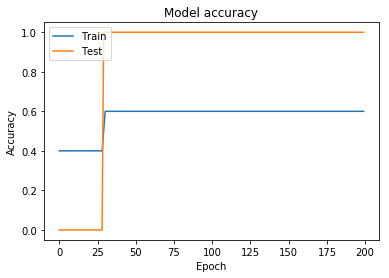

In [20]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

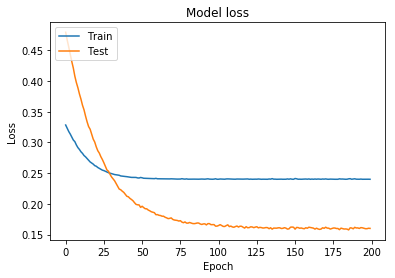

In [21]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
score1 = models.evaluate(X_test, y_test, batch_size=1)

print("Loss: " + str(score1[0]*100.0) + "%")
print("Accuracy: " + str(score1[1]*100.0) + "%")

2/2 [==============================] - 0s 897us/step
Loss: 25.998100638389587%
Accuracy: 50.0%


<b>Batch Size = Jumlah Data Latih</b>

In [23]:
history2 = models.fit(X_train, y_train, epochs=200, verbose=1, batch_size=len(X_train), validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/200
10/10 [==============================] - 0s 198us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 2/200
10/10 [==============================] - 0s 152us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 3/200
10/10 [==============================] - 0s 183us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 4/200
10/10 [==============================] - 0s 184us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 5/200
10/10 [==============================] - 0s 173us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 6/200
10/10 [==============================] - 0s 160us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 7/200
10/10 [==============================] - 0s 163us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 8/200
10/10 [=======

Epoch 62/200
10/10 [==============================] - 0s 195us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 63/200
10/10 [==============================] - 0s 136us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 64/200
10/10 [==============================] - 0s 138us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 65/200
10/10 [==============================] - 0s 144us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 66/200
10/10 [==============================] - 0s 128us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 67/200
10/10 [==============================] - 0s 167us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 68/200
10/10 [==============================] - 0s 163us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 69/200
10/10 [==============================] - 0s 173us

Epoch 123/200
10/10 [==============================] - 0s 173us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 124/200
10/10 [==============================] - 0s 189us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 125/200
10/10 [==============================] - 0s 211us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 126/200
10/10 [==============================] - 0s 183us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 127/200
10/10 [==============================] - 0s 175us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 128/200
10/10 [==============================] - 0s 162us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 129/200
10/10 [==============================] - 0s 200us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 130/200
10/10 [==============================] - 

Epoch 184/200
10/10 [==============================] - 0s 179us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 185/200
10/10 [==============================] - 0s 231us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 186/200
10/10 [==============================] - 0s 211us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 187/200
10/10 [==============================] - 0s 174us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 188/200
10/10 [==============================] - 0s 175us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 189/200
10/10 [==============================] - 0s 189us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 190/200
10/10 [==============================] - 0s 279us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 191/200
10/10 [==============================] - 

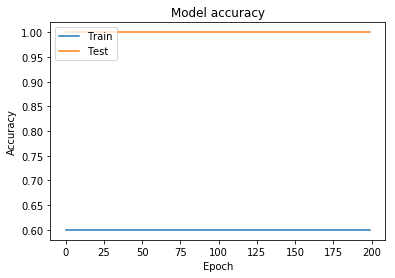

In [24]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

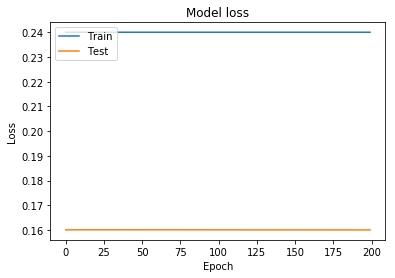

In [25]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
score2 = models.evaluate(X_test, y_test, batch_size=len(X_train))

print("Loss: " + str(score2[0]*100.0) + "%")
print("Accuracy: " + str(score2[1]*100.0) + "%")

2/2 [==============================] - 0s 246us/step
Loss: 25.998514890670776%
Accuracy: 50.0%
